In [1]:
import numpy as np
import matplotlib.pyplot as plt
import fitsio
import gaia_tools.load as gload
%matplotlib inline

/home/pedro/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Misión Gaia

Gaia es una de las misiones emblemáticas de la Agencia Espacial Europea de esta década. Tiene como objetivo clarificar el origen y evolución de nuestra galaxia. Para ello Gaia obtendrá un mapa 3D muy preciso de unos 1.000 millones de estrellas. Gracias a esta misión podremos por fin responder a preguntas sobre cómo se formó la Galaxia, qué forma tiene, el papel de la materia oscura en el Universo, cómo evolucionan las estrellas y muchos interrogantes más. (http://gaiavideo.ub.edu/, http://www.esa.int/Our_Activities/Space_Science/Gaia_overview)

Sus objetivos comprenden:

1. Medidas astrométricas (o posicionales), determinando las posiciones, distancias y movimiento propio anual de las estrellas.
2. Medidas fotométricas, obteniendo observaciones multicolor y multiépoca de cada objeto detectado.
3. Medidas de velocidad radial.

Gaia posee el catálogo TGAS (Tycho-Gaia Astrometric Solution), que posee os observables anteriormente mencionados.

RAVE-on es el una versión mejorada de RAVE que es un programa observacional del campo cercano cosmológico, es decir, posee datos mejor analizados y con errores mucho menores, sus mediciones están centradas en espectroscopia y por lo tanto en velocidades radiales de estrellas de la Vía Lactea. (https://www.rave-survey.org/project/introduction/)

Se descargan los catálogos

In [2]:
tgas_cat= gload.tgas()
raveon_cat= gload.raveon()

Se hace un match entre los catálogos.

In [3]:
import glob
from astropy.io.fits import getdata
from gaia_tools import xmatch

m1,m2,sep= xmatch.xmatch(raveon_cat,tgas_cat,colRA2='ra',colDec2='dec',epoch1=2000.,epoch2=2015.)

path_gaia = glob.glob("../Gaia/tgas_source/fits/*.fits")
path_raveon = "../raveon/DR5/RAVE-on-v1.0.fits"

data1,header1 = getdata(path_gaia[7],ext=1,header="True")
data2,header2 = getdata(path_raveon,ext=1,header="True")

#520701

A continuación se muestran los header para cada catálogo.

El header para el catálogo TGAS

In [4]:
header1

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional table                            
NAXIS1  =                  336 / width of table in bytes                        
NAXIS2  =                34075 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group                                 
TFIELDS =                   59 / number of columns                              
EXTNAME = 'TgasSource_000-000-015.fits' / table name                            
TTYPE1  = 'hip     '           / label for column 1                             
TFORM1  = 'J       '           / format for column 1                            
TNULL1  =          -2147483648 / blank value for column 1                       
TUCD1   = 'meta.id.cross'   

El header para el catálogo RAVE-on

In [5]:
header2

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  344 / length of dimension 1                          
NAXIS2  =               520701 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   58 / number of table fields                         
TTYPE1  = 'RAVE_OBS_ID'                                                         
TFORM1  = '31A     '                                                            
TTYPE2  = 'RAVEID  '                                                            
TFORM2  = '16A     '                                                            
TTYPE3  = 'RA      '        

De los fits de TGAS se exraen los datos coorespondientes a:
+ Magnitud fotométrica G.
+ Ángulo de paralaje.
+ Error en el ángulo de paralaje.
+ Movimientos propios en RA y en DEC.

Del fits de RAVE-on se exraen los datos coorespondientes a:
+ Temperatura efectiva.
+ RA y DEC
+ HRV (Heliocentric radial velocity)

In [6]:
def remove_nan_list(xarray,yarray):
    nans = np.isnan(yarray) #da un arreglo de boleanos de los elementos == np.nan
    index_nans = np.where(nans) #da los indices del arreglo donde la condicione es True (es un np.nan)
    for element in index_nans:
        xarray = np.delete(xarray,element)
        yarray = np.delete(yarray,element)
    return xarray, yarray

Se extraen los datos anteriormente mencionados.

In [7]:
Teff = raveon_cat[m1]['TEFF']
Mag = tgas_cat[m2]['phot_g_mean_mag']
parallax = tgas_cat[m2]["parallax"]
parallax_error = tgas_cat[m2]["parallax_error"]
ra = raveon_cat[m1]['RA']
dec = raveon_cat[m1]['DEC']
mu_alpha = tgas_cat[m2]["pmra"]
mu_delta = tgas_cat[m2]["pmdec"]
v_radial = raveon_cat[m1]['HRV']

/home/pedro/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in log10


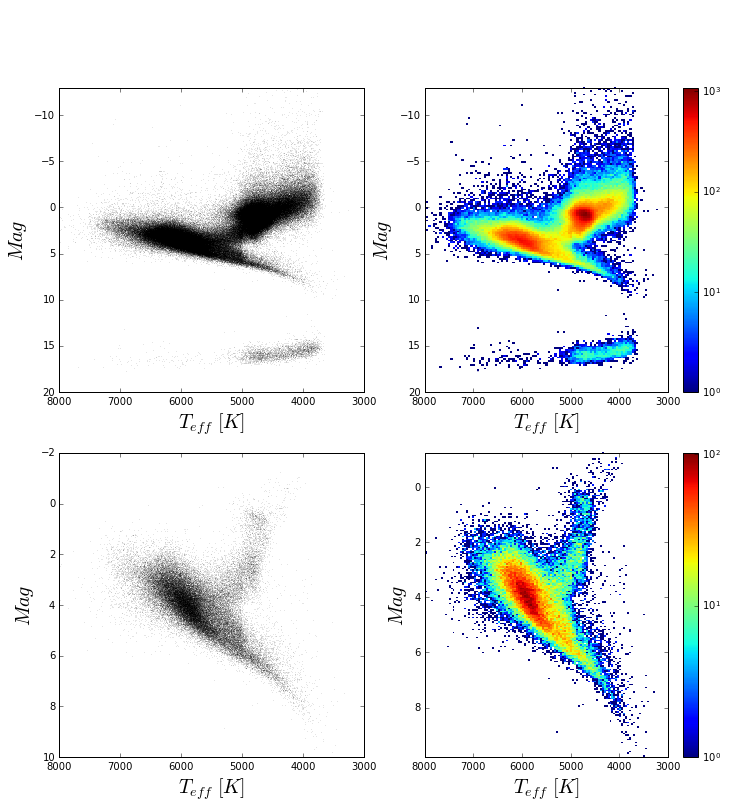

In [8]:
from matplotlib.colors import LogNorm                
    
Teff = raveon_cat[m1]['TEFF']

new_Teff, new_Mag_abs = [], []

for i in range(0,len(m2)):
    if parallax[i]/parallax_error[i] > 10: #seleccionamos los datos que tengan S/N > 10 en el paralaje
        new_Teff.append(Teff[i])
        new_Mag_abs.append(Mag[i]+5-5*np.log10(1000/parallax[i]))

Mag_abs = Mag + 5 - 5*np.log10(1000/parallax)
        
new_Mag_abs,new_Teff = remove_nan_list( new_Mag_abs,new_Teff )
Mag_abs,Teff = remove_nan_list( Mag_abs,Teff )

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=[6*2, 6*2])
ax[0,0].set_ylabel("$Mag$",fontsize=20)
ax[0,0].set_xlabel("$T_{eff}\ [K]$",fontsize=20)
ax[0,0].plot(Teff,Mag_abs,'.k',ms=1,alpha=0.1)
ax[0,0].set_ylim(-13,20)
ax[0,0].set_xlim(3000,8000)
ax[0,0].invert_yaxis() 
ax[0,0].invert_xaxis() 

ax[0,1].set_ylabel("$Mag$",fontsize=20)
ax[0,1].set_xlabel("$T_{eff}\ [K]$",fontsize=20)
ax01= ax[0,1].hist2d(Teff,Mag_abs, bins=200,norm=LogNorm())
ax[0,1].set_ylim(-13,20)
ax[0,1].set_xlim(3000,8000)
ax[0,1].invert_yaxis() 
ax[0,1].invert_xaxis() 
fig.colorbar(ax01[3],ax=ax[0,1])

ax[1,0].set_ylabel("$Mag$",fontsize=20)
ax[1,0].set_xlabel("$T_{eff}\ [K]$",fontsize=20)
ax[1,0].plot(new_Teff,new_Mag_abs,'.k',ms=1,alpha=0.1)
ax[1,0].set_xlim(3000,8000)
ax[1,0].invert_yaxis() 
ax[1,0].invert_xaxis() 

ax[1,1].set_ylabel("$Mag$",fontsize=20)
ax[1,1].set_xlabel("$T_{eff}\ [K]$",fontsize=20)
ax02= ax[1,1].hist2d(new_Teff,new_Mag_abs, bins=200,norm=LogNorm())
ax[1,1].set_xlim(3000,8000)
ax[1,1].invert_yaxis() 
ax[1,1].invert_xaxis() 
fig.colorbar(ax02[3],ax=ax[1,1])
plt.show()

En la parte superior se encuentran todas las estrellas sin el filtro de S/N > 10 y en la parte inferior estan los datos filtrados por S/N del paralaje. En los gráficos inferiores se puede apreciar la poblacion de estrellas en secuencia principal, y un brazo de la rama de las gigantes.

Luego Se procede a calcular el campo de velocidades en coordenadas galácticas rectangulares, los pasos a seguir fueron los empleados a partir del paper de *Dean R. H. Johnson & David R. Soderblom, 1987* y se obtubieron las velocidades $v_{x}$ y $v_{y}$

$T = \left[ \begin{array}{ccc}
-0.06699 & -0.87276 & -0.48354\\
0.49273 & -0.45035 & 0.74458\\
-0.86760 & -0.18837 & 0.46020\\
\end{array} \right]$

$A = \left[ \begin{array}{ccc}
cos(\alpha)cos(\delta)&-sin(\alpha)&-cos(\alpha)sin(\delta)\\
sin(\alpha)cos(\delta)&cos(\alpha)&-sin(\alpha)sin(\delta)\\
sin(\delta)&0&cos(\delta)\\
\end{array} \right]$

$
\left[\begin{array}{c}
v_{x} \\
v_{y} \\ 
v_{z} \\
\end{array}\right]=T\cdot A\cdot
\left[\begin{array}{c}
v_{r} \\
\frac{k}{\pi}\mu_{\alpha} \\ 
\frac{k}{\pi}\mu_{\delta} \\
\end{array}\right]
$

Donde k = 4.74047 $\frac{Km}{s}yr$, $\pi$ es el paralaje en $as$, $v_{r}$ es la velocidad radial en Km/s, $\mu_{\alpha},\ \mu_{\delta}$ son los movimientos propios en RA y DEC respectivamente medidos en $\frac{as}{yr}$ y $\alpha,\ \delta$ son las coordenadas RA y DEC medidas en $as$ respectivamente.  

NOTA: La matriz $T$ es calculada a partir de datos del año 1950, los datos obtenidos son del 2000, esta conversión a entre los años solo dará como resultado una rotación de la distribución de velocidades, pero no afectará la forma, debido a esto, se procede sin la conversión entre fechas.

In [9]:
T = np.matrix([[-.06699, -.87276, -.48354],
              [.49273, -.45035, .74458],
              [.8676, -.18837, .4602]])

vec_vels = []
k = 4.74047

for i in range(0,len(m2)):
    if parallax[i]/parallax_error[i] > 10:
        alpha, delta = np.radians(ra[i]), np.radians(dec[i])
        v_r ,v_alpha, v_delta = v_radial[i], mu_alpha[i]/1000, mu_delta[i]/1000
        omega = parallax[i]/1000


        A = np.matrix([[np.cos(alpha)*np.cos(delta),-np.sin(alpha),-np.cos(alpha)*np.sin(delta)],
                       [np.sin(alpha)*np.cos(delta),np.cos(alpha),-np.sin(alpha)*np.sin(delta)],
                       [np.sin(delta),0,np.cos(delta)]])

        V_icrs = np.matrix([v_r,(k/omega)*v_alpha,(k/omega)*v_delta])
        V_xyz = np.dot(np.dot(T,A),V_icrs.getT())
        vec_vels.append(V_xyz.A1)

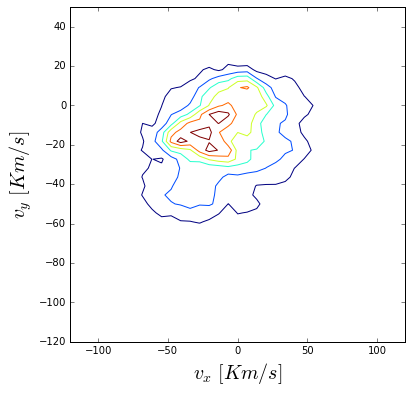

In [10]:
vec_vels = np.array(vec_vels)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=[6,6])
counts,xbins,ybins,image = ax.hist2d(vec_vels[:,0],vec_vels[:,1], bins=45,range=[[-150, 150], [-150, 50]])
ax.clear()
ax.contour(counts.transpose(),7,extent=(-150, 150,-150, 50) )
ax.set_ylabel("$v_{y}\ [Km/s]$",fontsize=20)
ax.set_xlabel("$v_{x}\ [Km/s]$",fontsize=20)
ax.set_xlim(-120,120)
ax.set_ylim(-120,50)
plt.show()


Se obtubo la districución de velocidades para $v_{x}$ y $v_{y}$ en coordenadas galácticas rectangulares, y a continuación se muestra la figura 21 del paper de *Jo Bovy, David W. Hogg & Sam T. Roweis, 2009*

![alt text](https://github.com/Pedro73/Astro-Exp/blob/master/Tarea%203/Parte%20I/figura%2021.png)

Es posible notar todas las estructuras centrales tales como Coma Berenices, NGC 1901, Hyades, Sirius/UMa, Peiades y Hercules es algo más discutible, pero no se obtubo Arcturus. Debido a que ambas giguras fueron calculadas con medios distintos, es decir, este trabajo se hizo con los datos de Gaia y la figura anterior fue obtenida con HIPPARCOS por lo que se confirnam los datos de HIPPARCOS. Recordemos que HIPPARCOS es el predecesor de Gaia, que posee el mismo objetivo y en su tiempo produjo el mayor numero de estrellas catalogadas. (http://www.cosmos.esa.int/web/hipparcos)